In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download hbahruz/eye-pupil-detection

Dataset URL: https://www.kaggle.com/datasets/hbahruz/eye-pupil-detection
License(s): other
100% 107M/107M [00:06<00:00, 23.0MB/s]
100% 107M/107M [00:06<00:00, 18.3MB/s]


In [ ]:
!unzip eye-pupil-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/labels/05655.txt  
  inflating: dataset/labels/05656.txt  
  inflating: dataset/labels/05657.txt  
  inflating: dataset/labels/05658.txt  
  inflating: dataset/labels/05659.txt  
  inflating: dataset/labels/05660.txt  
  inflating: dataset/labels/05661.txt  
  inflating: dataset/labels/05662.txt  
  inflating: dataset/labels/05663.txt  
  inflating: dataset/labels/05664.txt  
  inflating: dataset/labels/05665.txt  
  inflating: dataset/labels/05666.txt  
  inflating: dataset/labels/05667.txt  
  inflating: dataset/labels/05668.txt  
  inflating: dataset/labels/05669.txt  
  inflating: dataset/labels/05670.txt  
  inflating: dataset/labels/05671.txt  
  inflating: dataset/labels/05672.txt  
  inflating: dataset/labels/05673.txt  
  inflating: dataset/labels/05674.txt  
  inflating: dataset/labels/05675.txt  
  inflating: dataset/labels/05676.txt  
  inflating: dataset/labels/05677.txt  
  inflating: dataset/labels/0

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class EyeDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
        self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")
        original_width, original_height = img.size

        # Load labels
        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        with open(label_path, "r") as f:
            labels = list(map(float, f.readline().strip().split()))

        is_left, is_right, left_x, left_y, right_x, right_y = labels

        # Normalize coordinates
        left_x = left_x / original_width if is_left == 1 else -1
        left_y = left_y / original_height if is_left == 1 else -1
        right_x = right_x / original_width if is_right == 1 else -1
        right_y = right_y / original_height if is_right == 1 else -1

        target = torch.tensor([left_x, left_y, right_x, right_y], dtype=torch.float32)

        # Apply transforms to the image
        if self.transform:
            img = self.transform(img)

        return img, target

In [ ]:
# Dataset paths
images_dir = "dataset/images"
labels_dir = "dataset/labels"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [ ]:
dataset = EyeDataset(images_dir, labels_dir, transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class MobileNetV3Custom(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNetV3Custom, self).__init__()
        # Load pretrained MobileNetV3
        self.base_model = models.mobilenet_v3_small(pretrained=pretrained)
        # Modify the classifier head
        in_features = self.base_model.classifier[0].in_features
        self.base_model.classifier = nn.Identity()  # Remove the default head

        # Custom regression head
        self.coords_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 4),  # Regression for left_x, left_y, right_x, right_y
        )

    def forward(self, x):
        features = self.base_model(x)
        coords = self.coords_head(features)
        return coords

In [ ]:
model = MobileNetV3Custom(pretrained=True)

regression_loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [ ]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        coords_pred = model(images)

        # Compute loss
        loss = regression_loss_fn(coords_pred, targets)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)

            coords_pred = model(images)
            loss = regression_loss_fn(coords_pred, targets)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Save the model
torch.save(model.state_dict(), "mobilenetv3_coords.pth")

Epoch 1/20, Training Loss: 2.0413, Validation Loss: 0.4214
Epoch 2/20, Training Loss: 0.8886, Validation Loss: 0.0803
Epoch 3/20, Training Loss: 0.5938, Validation Loss: 0.3783
Epoch 4/20, Training Loss: 0.6441, Validation Loss: 0.6366
Epoch 5/20, Training Loss: 0.6373, Validation Loss: 0.1472
Epoch 6/20, Training Loss: 0.3368, Validation Loss: 0.0733
Epoch 7/20, Training Loss: 0.2970, Validation Loss: 0.1418
Epoch 8/20, Training Loss: 0.4831, Validation Loss: 0.1776
Epoch 9/20, Training Loss: 0.4687, Validation Loss: 0.1285
Epoch 10/20, Training Loss: 0.3628, Validation Loss: 0.0728
Epoch 11/20, Training Loss: 0.3529, Validation Loss: 0.0468
Epoch 12/20, Training Loss: 0.2524, Validation Loss: 0.0492
Epoch 13/20, Training Loss: 0.3336, Validation Loss: 0.1651
Epoch 14/20, Training Loss: 0.2953, Validation Loss: 0.0313
Epoch 15/20, Training Loss: 0.2074, Validation Loss: 0.2359
Epoch 16/20, Training Loss: 0.2923, Validation Loss: 0.0526
Epoch 17/20, Training Loss: 0.2711, Validation Lo

In [ ]:
test_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# Load the fine-tuned model
model = MobileNetV3Custom(pretrained=False)
model.load_state_dict(torch.load("mobilenetv3_coords.pth"))
model.eval()
model.to(device)

# Function to denormalize coordinates
def denormalize_coords(coords, original_width, original_height):
    coords[0] = coords[0] * original_width if coords[0] != -1 else -1
    coords[1] = coords[1] * original_height if coords[1] != -1 else -1
    coords[2] = coords[2] * original_width if coords[2] != -1 else -1
    coords[3] = coords[3] * original_height if coords[3] != -1 else -1
    return coords

<ipython-input-20-6c6a85aac635>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mobilenetv3_coords.pth"))


Predicted Pupil Coordinates (Pixel):
Left Eye: (73.42471313476562, 40.52179718017578)
Right Eye: (206.6870880126953, 44.12071228027344)


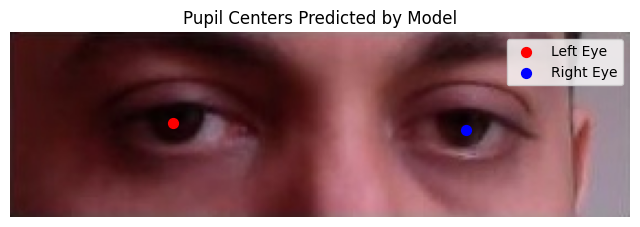

In [ ]:
test_index = 100  # You can change this to test other images

# Get the original image path from the test dataset
test_img_path = os.path.join(images_dir, dataset.image_files[test_dataset.indices[test_index]])
original_img = Image.open(test_img_path).convert("RGB")
original_width, original_height = original_img.size

# Transform and prepare the test image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
test_img_tensor = transform(original_img).unsqueeze(0).to(device)

# Get model predictions
with torch.no_grad():
    preds = model(test_img_tensor).cpu().numpy()[0]

# Denormalize the coordinates
denormalized_preds = denormalize_coords(preds.copy(), original_width, original_height)

# Display predicted pixel coordinates
print(f"Predicted Pupil Coordinates (Pixel):")
print(f"Left Eye: ({denormalized_preds[0]}, {denormalized_preds[1]})")
print(f"Right Eye: ({denormalized_preds[2]}, {denormalized_preds[3]})")

# Convert image to numpy array for visualization
original_img_np = np.array(original_img)

# Plot the image and overlay the predicted points
plt.figure(figsize=(8, 8))
plt.imshow(original_img_np)
if denormalized_preds[0] != -1 and denormalized_preds[1] != -1:  # Left eye exists
    plt.scatter(denormalized_preds[0], denormalized_preds[1], c='red', s=50, label="Left Eye")
if denormalized_preds[2] != -1 and denormalized_preds[3] != -1:  # Right eye exists
    plt.scatter(denormalized_preds[2], denormalized_preds[3], c='blue', s=50, label="Right Eye")
plt.legend()
plt.title("Pupil Centers Predicted by Model")
plt.axis("off")
plt.show()